<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/parkinsons_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy anndata umap-learn python-igraph louvain h5py leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Success

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/HODD/Kamath_et_al_2022")

In [4]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import scipy.sparse

# File paths
meta_path = "METADATA_PD.tsv.gz"
matrix_path = "GSE178265_Homo_matrix.mtx.gz"
barcodes_path = "GSE178265_Homo_bcd.tsv.gz"
features_path = "Homo_features.tsv"

# Load sparse count matrix
X = mmread(matrix_path).tocsc()  # Convert to Compressed Sparse Column format for efficiency

# Load barcodes (cell IDs)
barcodes = pd.read_csv(barcodes_path, header=None, sep="\t")[0].values  # Read as a NumPy array

# Load gene names/features
genes = pd.read_csv(features_path, header=None, sep="\t")[0].values  # Read as a NumPy array

# Create AnnData object
adata = sc.AnnData(X.T)
adata.obs_names = barcodes  # Assign cell barcodes
adata.var_names = genes  # Assign gene names

# Load the metadata
metadata_df = pd.read_csv(meta_path, sep="\t")  # Adjust delimiter if needed
metadata_df = metadata_df.drop(metadata_df.index[0])  # Drops unnecessary row
metadata_df = metadata_df.reset_index(drop=True)  # Resets the index values

# Ensure "Name" is the barcode column before setting it as the index
metadata_df = metadata_df.set_index("NAME")

# Reorder metadata to match AnnData object & handle missing barcodes safely
metadata_df = metadata_df.reindex(adata.obs_names)  # Ensures the same order, fills missing barcodes with NaN

# Assign the DataFrame to adata.obs
adata.obs = metadata_df

# Verify
print(adata)


<ipython-input-4-ae10219a81e3>:27: DtypeWarning: Columns (3,13,14,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(meta_path, sep="\t")  # Adjust delimiter if needed


AnnData object with n_obs × n_vars = 434340 × 41625
    obs: 'libname', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'date', 'Donor_Age', 'Donor_PMI', 'Status', 'Cause_of_Death', 'FACS_Classification'


In [7]:
adata.obs

,libname,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,date,Donor_Age,Donor_PMI,Status,Cause_of_Death,FACS_Classification
pPDCN4340DAPIA030419_AATGCCACACAAGCAG-1,pPDCN4340DAPIA030419,pPDCN4340DAPIA030419,4340,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001873,caudate nucleus,EFO_0009901,10x 3' v1,male,190304,47,12.5,Ctrl,Esophageal cancer with liver mets,Negative
pPDCN4340DAPIA030419_AGACTCAGTCACAATC-1,pPDCN4340DAPIA030419,pPDCN4340DAPIA030419,4340,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001873,caudate nucleus,EFO_0009901,10x 3' v1,male,190304,47,12.5,Ctrl,Esophageal cancer with liver mets,Negative
pPDCN4340DAPIA030419_ATACTTCCAGCGTTGC-1,pPDCN4340DAPIA030419,pPDCN4340DAPIA030419,4340,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001873,caudate nucleus,EFO_0009901,10x 3' v1,male,190304,47,12.5,Ctrl,Esophageal cancer with liver mets,Negative
pPDCN4340DAPIA030419_ATATCCTGTGTGTTTG-1,pPDCN4340DAPIA030419,pPDCN4340DAPIA030419,4340,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001873,caudate nucleus,EFO_0009901,10x 3' v1,male,190304,47,12.5,Ctrl,Esophageal cancer with liver mets,Negative
pPDCN4340DAPIA030419_ATCCACCGTGGGTTGA-1,pPDCN4340DAPIA030419,pPDCN4340DAPIA030419,4340,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001873,caudate nucleus,EFO_0009901,10x 3' v1,male,190304,47,12.5,Ctrl,Esophageal cancer with liver mets,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pPDsHSrSNxi3298d200429PosB_CATACTTGTCTGATCA-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,10x 3' v1,male,200429,79,22,Ctrl,Prostate cancer,Positive
pPDsHSrSNxi3298d200429PosB_TTTGTTGTCCTTGAAG-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,10x 3' v1,male,200429,79,22,Ctrl,Prostate cancer,Positive
pPDsHSrSNxi3298d200429PosB_ACACTGACACTAGAGG-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,10x 3' v1,male,200429,79,22,Ctrl,Prostate cancer,Positive
pPDsHSrSNxi3298d200429PosB_CAACAACAGCTCGAAG-1,pPDsHSrSNxi3298d200429PosB,pPDsHSrSNxi3298d200429PosB,3298,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0001965,substantia nigra pars compacta,EFO_0009901,10x 3' v1,male,200429,79,22,Ctrl,Prostate cancer,Positive


In [9]:
# subset the data for NR4A2 positive nuclei

adata = adata[adata.obs["FACS_Classification"] == "Positive"].copy()

In [10]:
# calculate standard quality control metrics

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [11]:
# subset by counts and mitochondrial reads
adata = sc.pp.filter_cells(adata, min_genes=200)
adta = sc.pp.filter_genes(adata, min_cells=3)


Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'MT-RNR1',
       'MT-RNR2', 'MT-TC', 'MT-TD', 'MT-TF', 'MT-TG', 'MT-TH', 'MT-TI',
       'MT-TL1', 'MT-TL2', 'MT-TM', 'MT-TP', 'MT-TR', 'MT-TS2', 'MT-TT',
       'MT-TV', 'MT-TY'],
      dtype='object')


In [12]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


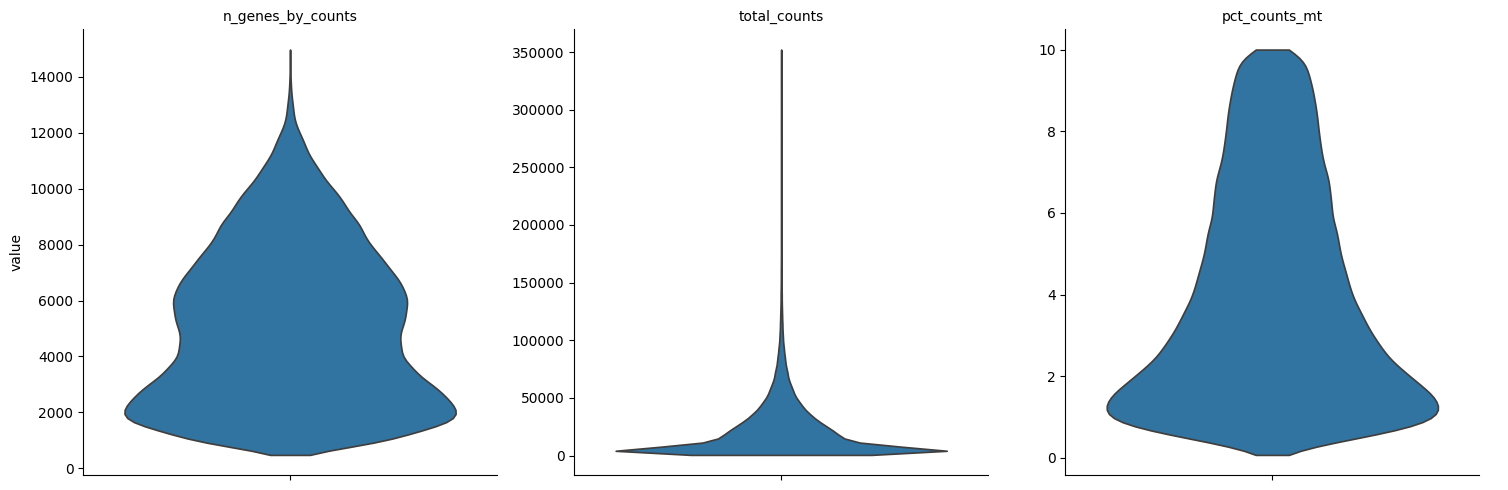

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    stripplot=False,
    multi_panel=True,
)

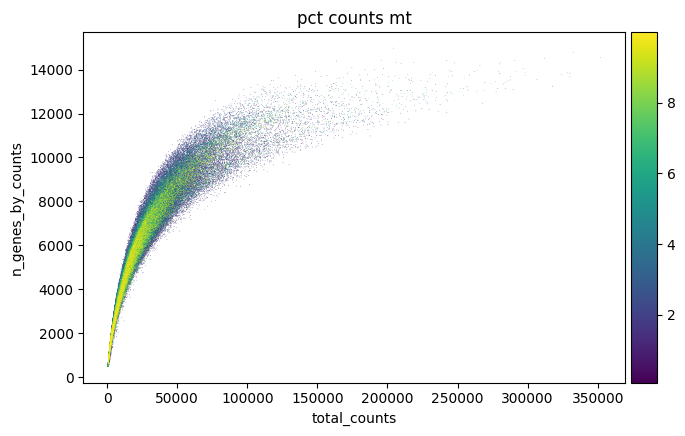

In [14]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [15]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [16]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

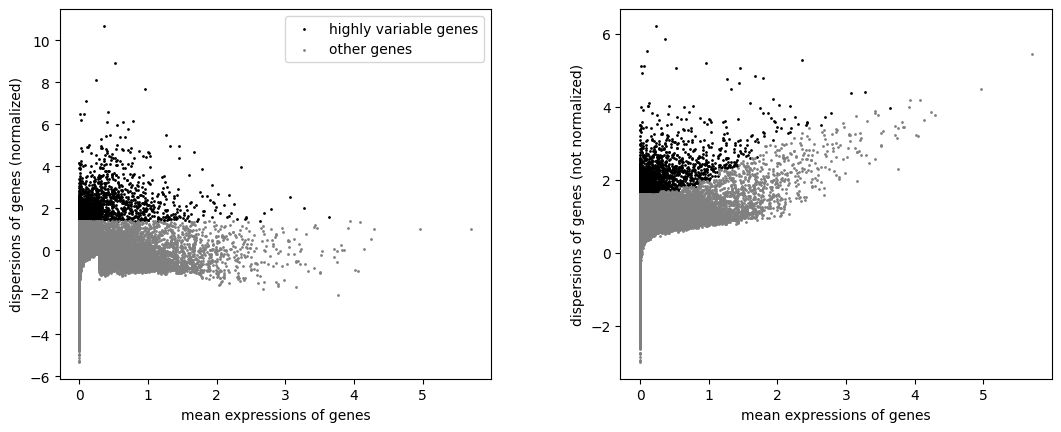

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
sc.tl.pca(adata, n_comps=15)  # Reduce to 15 PCs

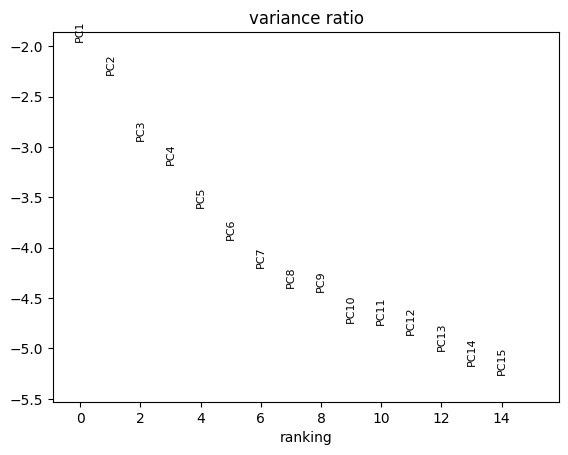

In [20]:
sc.pl.pca_variance_ratio(adata, n_pcs=15, log=True)

In [21]:
sc.pp.neighbors(adata)


In [22]:
sc.tl.umap(adata)

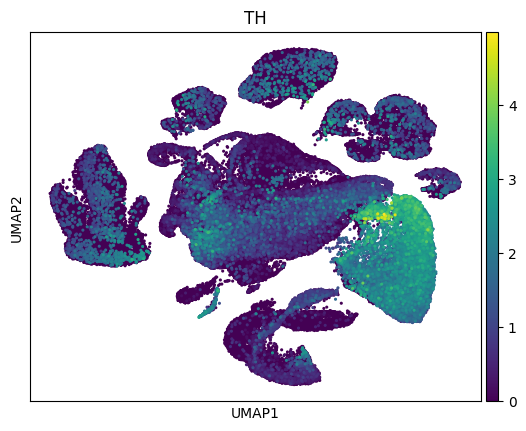

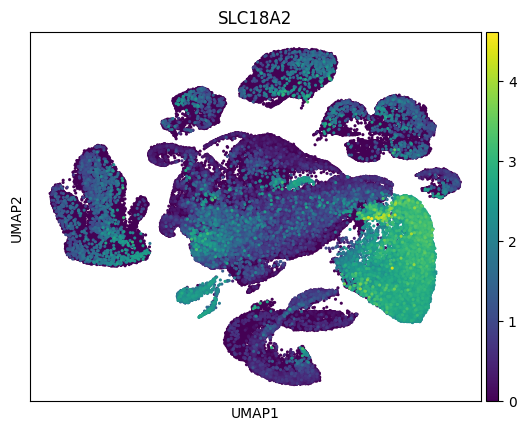

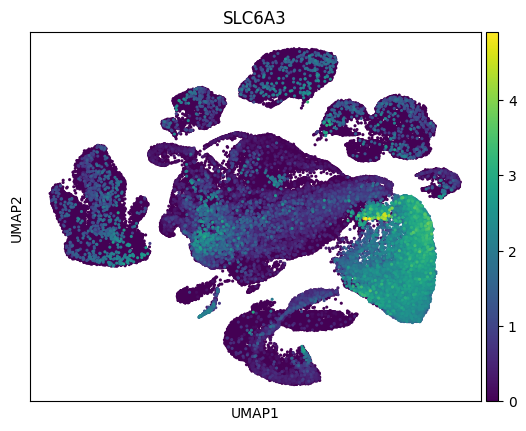

In [27]:
sc.pl.umap(adata, color="TH", cmap="viridis", size=20)
sc.pl.umap(adata, color="SLC18A2", cmap="viridis", size=20)
sc.pl.umap(adata, color="SLC6A3", cmap="viridis", size=20)

In [36]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.1)

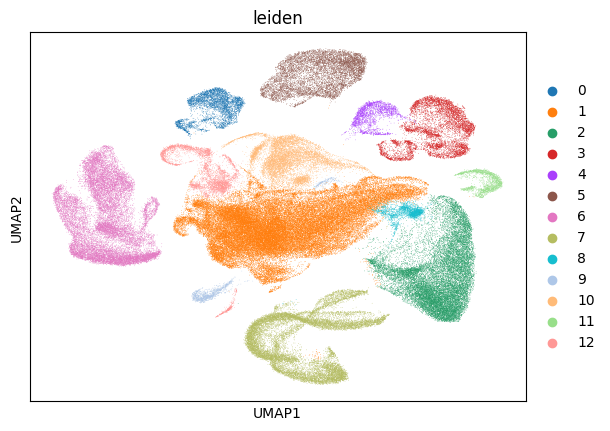

In [46]:
sc.pl.umap(adata, color=["leiden"])

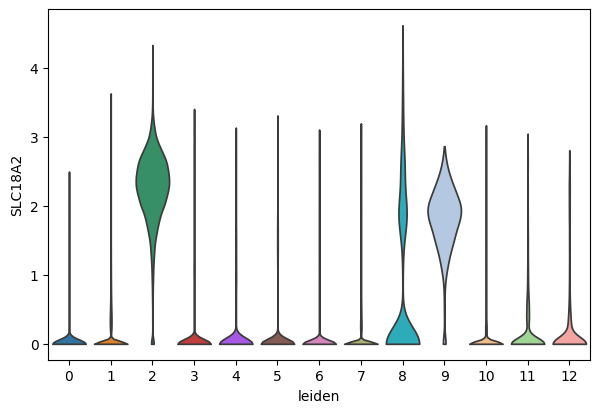

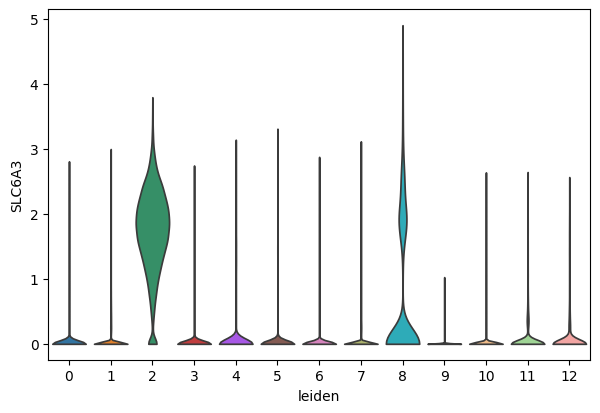

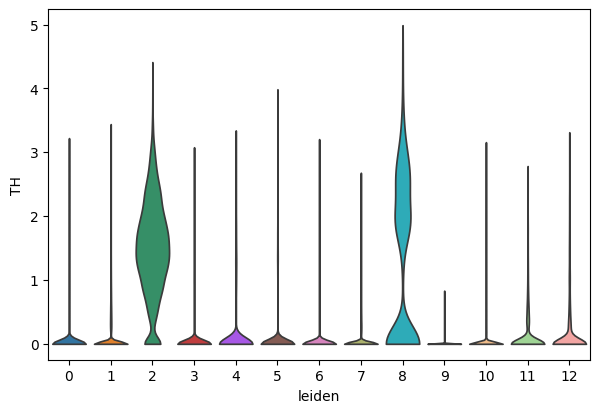

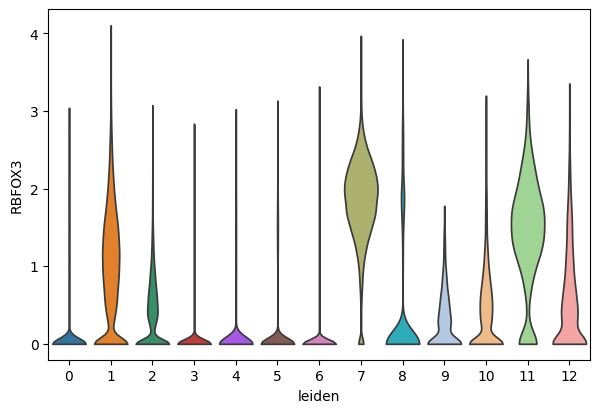

In [45]:
# List of marker genes (replace with your genes of interest)
marker_genes = ["SLC18A2", "SLC6A3", "TH", "RBFOX3"]

# Create violin plots for each gene
for gene in marker_genes:
    # Create the violin plot
    plt = sc.pl.violin(adata,
                 keys=gene,                    # Gene of interest
                 groupby="leiden",              # Grouping by clusters
                 stripplot=False,                # Show stripplot dots for individual cells
                 jitter=0.4,                    # Adjust jitter for stripplot
                 size=20)                       # Adjust plot size


In [ ]:
adata.write('/content/drive/MyDrive/HODD/kamath_adata_file_procssed.h5ad')

In [ ]:
print('test')

In [49]:
adata.obs['leiden'].value_counts()

,count
leiden,
1,54383
2,19453
6,18750
7,16535
10,8823
5,7784
3,6949
12,4535
0,4136
